In [0]:
!pip install import_ipynb
!pip uninstall tensorflow
!pip uninstall keras
!pip install tensorflow-gpu
!pip install keras

In [0]:
from keras import models
from keras.models import Model
from keras.layers import  Dropout, Activation, Conv2D, MaxPooling2D, Input, Concatenate, Conv2DTranspose
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [0]:
class Unet(object):
    
    def __init__(self, input_size, lr = 0.001):
        
        self.input_size = input_size
        self.lr = lr
        self.model = self.create_model()
        
    def left_level(self, input, filter):
        conv_1 = Conv2D(filter, (3,3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal')(input)
        conv_2 = Conv2D(filter, (3,3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal')(conv_1)
        max_pool = MaxPooling2D((2,2), (2,2))(conv_2)
        
        return max_pool, conv_2
    
    def right_level(self, input, concat_input, filter):
        concat = Concatenate(axis=3)([Conv2DTranspose(filter, (3,3), activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal', padding = 'same')(input), concat_input])
        conv_1 = Conv2D(filter, (3,3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal')(concat)
        conv_2 = Conv2D(filter, (3,3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal')(conv_1)
        
        return conv_2
    
    def left_level_layers(self, input):
        left_level_1, concat_1 = self.left_level(input, 64)
        left_level_2, concat_2 = self.left_level(left_level_1, 128)
        left_level_3, concat_3 = self.left_level(left_level_2, 256)
        left_level_4, concat_4 = self.left_level(left_level_3, 512)
        
        return concat_1, concat_2, concat_3, concat_4, left_level_4
    
    def deepest_layer(self, input):
        deepest_level_1 = Conv2D(1024, (3,3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal')(input)
        deepest_level_2 = Conv2D(1024, (3,3), activation='relu', strides=1, padding='same', kernel_initializer='he_normal')(deepest_level_1)
        
        return deepest_level_2
        
    def right_level_layers(self, input, concat_1, concat_2, concat_3, concat_4):
        right_level_4 = self.right_level(input, concat_4, 512)
        right_level_3 = self.right_level(right_level_4, concat_3, 256)
        right_level_2 = self.right_level(right_level_3, concat_2, 128)
        right_level_1 = self.right_level(right_level_2, concat_1, 64)
        
        return right_level_1
    
    def create_model(self):
        input = Input(self.input_size)
        concat_1, concat_2, concat_3, concat_4, left_level_4 = self.left_level_layers(input)
        deepest_level = self.deepest_layer(left_level_4)
        right_level_1 = self.right_level_layers(deepest_level, concat_1, concat_2, concat_3, concat_4)
        
        final_layer = Conv2D(4, (1,1), activation='relu', strides=1, padding='same', kernel_initializer='he_normal')(right_level_1)
        final_layer = Activation('softmax')(final_layer)
        model = Model(inputs=input, outputs=final_layer)
        model.compile(optimizer=Adam(learning_rate=self.lr), loss= 'categorical_crossentropy',metrics=['accuracy'])
        
        return model
    
    def predict(self, img):
        return self.model.predict(img)
    
    def load_weights(self, weights):
        self.model.load_weights(weights)

    
    def train_generator(self, img_train, mask_train, img_test, mask_test, epoch = 10, batch_size = 8):

        train_datagen = ImageDataGenerator(
            rescale=1/255,
            brightness_range=[0.7, 1.3]
        )

        val_datagen = ImageDataGenerator(
            rescale=1/255
        )

        train_gen = train_datagen.flow(
            x_train,
            y_train,
            batch_size = batch_size,
            shuffle=True
        )

        val_gen = val_datagen.flow(
            x_test,
            y_test,
            batch_size = batch_size,
            shuffle=False
        )

        checkpoint = ModelCheckpoint('unet_weights' + '.h5', monitor = 'val_accuracy', save_best_only = True, verbose = 1)

        self.history = self.model.fit_generator(train_gen, validation_data=val_gen, epochs=epoch, callbacks=[checkpoint])
        
        return self.history

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import import_ipynb 
# from Unet import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
import os

In [0]:
img_train = np.load('/content/drive/My Drive/project/data/img_train.npy').astype(np.float32)
mask_train = np.load('/content/drive/My Drive/project/data/one_hot_label_train.npy').astype(np.float32)
img_test = np.load('/content/drive/My Drive/project/data/img_test.npy').astype(np.float32)
mask_test = np.load('/content/drive/My Drive/project/data/one_hot_label_test.npy').astype(np.float32)

In [0]:
model = Unet(img_train[0].shape)

In [0]:
history = model.train_generator(img_train, mask_train, img_test, mask_test, epoch = 20, batch_size = 8)

In [0]:
def test_test_data(index, model):
  model = load_model(model)
  img = img_test[index]/255
  pred = model.predict(img.reshape([1, 256, 256, 3]))
  pred = np.argmax(pred, axis = 3)
  empty = np.zeros((pred.shape))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



  # reference: https://stackoverflow.com/questions/9295026/matplotlib-plots-removing-axis-legends-and-white-spaces
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.axis('off')
  plt.imshow(np.squeeze(img))
  masked_imclass = np.ma.masked_where(np.squeeze(pred) == 3, np.squeeze(empty))
  plt.imshow(masked_imclass)


  fig.savefig('ori_' + str(index) + '.png',bbox_inches='tight', pad_inches = 0)

  clothing_index = np.argwhere(np.squeeze(pred) == 3)
  max_cloth_index = clothing_index.max(axis=0)
  min_cloth_index = clothing_index.min(axis=0)
  max_x = max_cloth_index[1]
  max_y = max_cloth_index[0]
  min_x = min_cloth_index[1]
  min_y = min_cloth_index[0]

  fig_1 = plt.figure()
  plt.subplot(1,2,2)
  plt.axis('off')
  plt.imshow(img[min_y:max_y,min_x:max_x])
  plt.imshow(masked_imclass[min_y:max_y,min_x:max_x])
  fig_1.savefig('resized_' + str(index) + '.png',bbox_inches='tight', pad_inches = 0)

In [0]:
test_test_data(100, 'unet_weights.h5') # test_data has 150 imgs to test

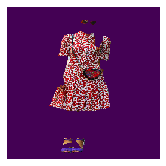

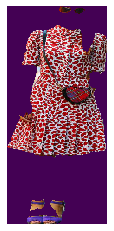

In [18]:
# test_test_data(30, '/content/drive/My Drive/project/unet_weights.h5')

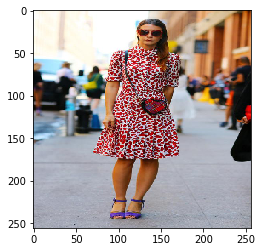

In [19]:
# plt.imshow(cv2.cvtColor(np.squeeze(img_test[40]/255), cv2.COLOR_BGR2RGB))

In [0]:
def test_custom_img(img_path, model):
  model = load_model(model)
  img = cv2.imread(img_path, 1)
  img = cv2.resize(img, dsize=(256, 256))
  pred = model.predict(img.reshape([1, 256, 256, 3])/255)
  pred = np.argmax(pred, axis = 3)
  empty = np.zeros((pred.shape))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # reference: https://stackoverflow.com/questions/9295026/matplotlib-plots-removing-axis-legends-and-white-spaces
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.axis('off')
  plt.imshow(np.squeeze(img))
  masked_imclass = np.ma.masked_where(np.squeeze(pred) == 3, np.squeeze(empty))
  plt.imshow(masked_imclass)


  name = os.path.splitext(img_path)[0]

  fig.savefig('ori_' + name + '.png' ,bbox_inches='tight', pad_inches = 0)

  clothing_index = np.argwhere(np.squeeze(pred) == 3)
  max_cloth_index = clothing_index.max(axis=0)
  min_cloth_index = clothing_index.min(axis=0)
  max_x = max_cloth_index[1]
  max_y = max_cloth_index[0]
  min_x = min_cloth_index[1]
  min_y = min_cloth_index[0]

  fig_1 = plt.figure()
  plt.subplot(1,2,2)
  plt.axis('off')
  plt.imshow(img[min_y:max_y,min_x:max_x])
  plt.imshow(masked_imclass[min_y:max_y,min_x:max_x])
  fig_1.savefig('resized_' + name + '.png',bbox_inches='tight', pad_inches = 0)
  

In [0]:
# test_custom_img('sample1.jpg','unet_weights.h5')

In [0]:
print(model.evaluate(img_test, mask_test, 16))
model.metrics_names

In [0]:
def show_val_acc_loss(history):
    fig = plt.figure()
    plt.plot(history['val_loss'])
    plt.title("UNet_val_acc_loss")
    plt.plot(history['val_accuracy'])
    plt.ylabel('Value')
    plt.xlabel('Epochs')
    plt.legend(['Val_loss', 'Val_acc'], loc=0)
    fig.savefig("UNet_val_acc_loss.png")

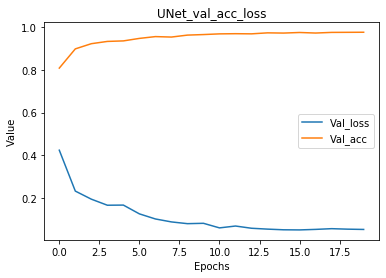

In [78]:
show_val_acc_loss(history.history)

In [0]:
def show_acc_loss(history):
    fig = plt.figure()
    plt.plot(history['loss'])
    plt.title("UNet_trian_acc_loss")
    plt.plot(history['accuracy'])
    plt.ylabel('Value')
    plt.xlabel('Epochs')
    plt.legend(['train_loss', 'trian_acc'], loc=0)
    fig.savefig("UNet_acc_loss.png")

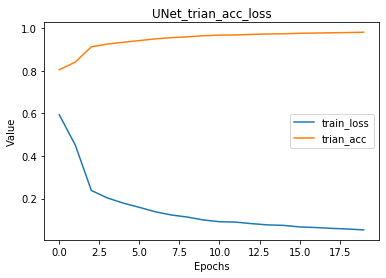

In [73]:
show_acc_loss(history.history)
